# Data Preparation

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils.utils import show_group_stats_viz, aggregate_dataset, preprocess_df
pd.set_option('display.max_columns', 500)
# this allows to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv.

Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/.

In [3]:
dataset_path = './data/final_project_dataset.csv'
df = pd.read_csv(dataset_path)
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [4]:
df['encounter_id'].nunique(), df['patient_nbr'].nunique(), len(df)

(101766, 71518, 143424)

**Response:** The dataset is at the line level.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
<br>a. Field(s) with high amount of missing/zero values
<br>b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
<br>c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
<br>d. Please describe the demographic distributions in the dataset for the age and gender fields.

### Null and missing values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [6]:
for col in df.columns:
    if df[col].isna().sum() > 0:
        print(col, df[col].isna().sum())

ndc_code 23462


In [7]:
for col in df.columns:
    if df[col].dtypes == 'O':
        if df[col].str.contains('\?').sum() > 0:
            print(col, df[col].str.contains('\?').sum())

race 3309
weight 139122
payer_code 54190
medical_specialty 69463
primary_diagnosis_code 33
other_diagnosis_codes 1984


In [8]:
for col in df.columns:
    if df[col].dtypes == 'int64':
        if len(df[df[col] == 0]):
            print(col, len(df[df[col] == 0]))

number_outpatient 120027
number_inpatient 96698
number_emergency 127444
num_procedures 65788


### Gaussian distribution

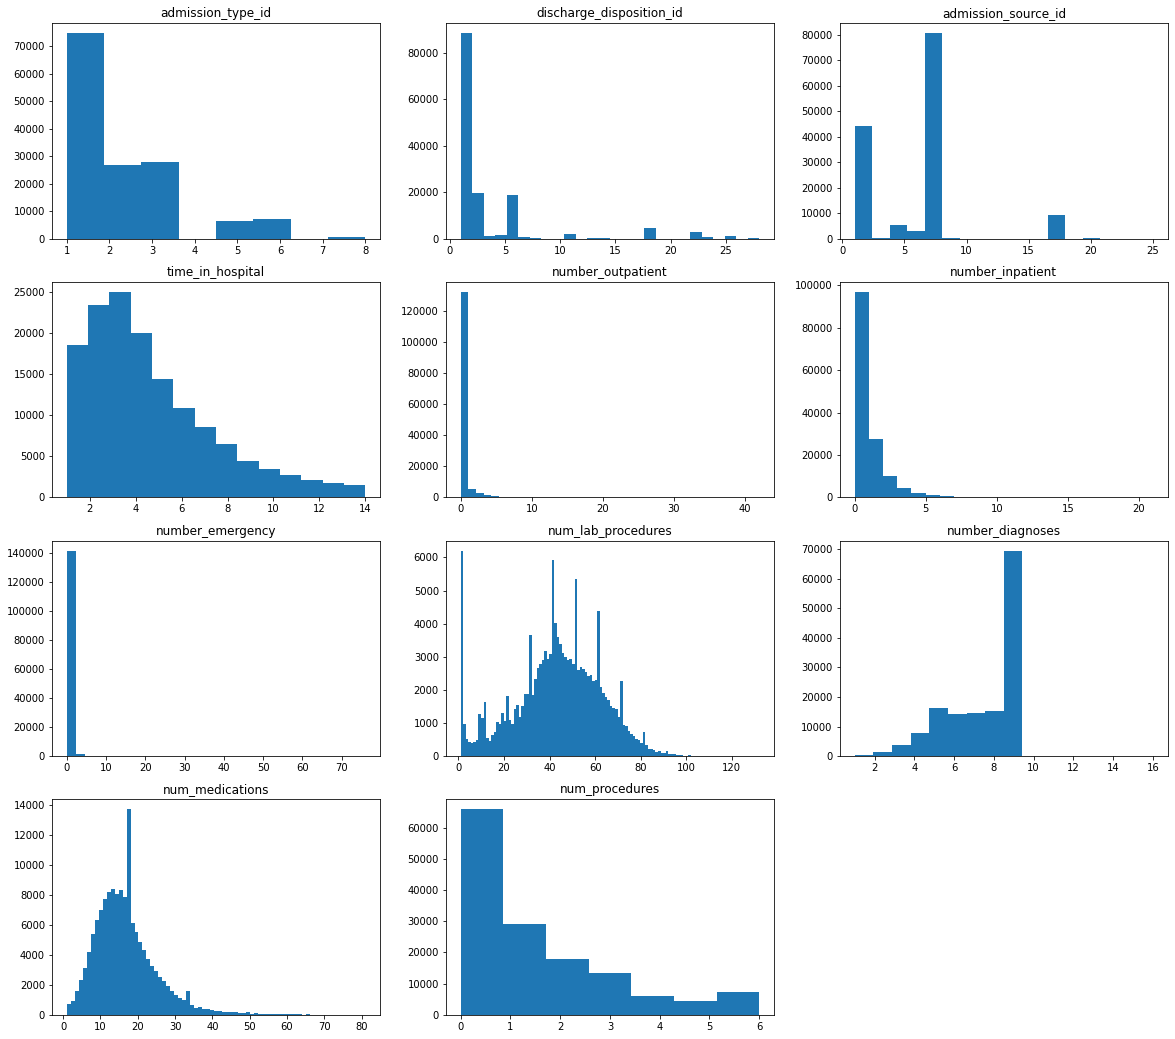

In [9]:
num_columns = [col for col in df.columns if df[col].dtypes == 'int64']
num_columns.remove('encounter_id')
num_columns.remove('patient_nbr')
plt.figure(figsize=(20,23))
i = 1
for col in num_columns:
    plt.subplot(5,3,i)
    plt.hist(df[col].values, bins=df[col].nunique())
    plt.title(col)
    i += 1

The following features have Gaussian distribution: 'num_labe_procedures', 'num_medications'.

### Cardinality

In [10]:
cardinality_df = pd.DataFrame(columns=['feature', 'cardinality'])

for col in df.columns:
    if df[col].dtypes == 'O':
        cardinality_df = cardinality_df.append(pd.DataFrame([[col, df[col].nunique()]], columns=['feature', 'cardinality']))
    
cardinality_df.sort_values(by='cardinality', ascending=False)

,feature,cardinality
0,other_diagnosis_codes,19374
0,primary_diagnosis_code,717
0,ndc_code,251
0,medical_specialty,73
0,payer_code,18
0,age,10
0,weight,10
0,race,6
0,max_glu_serum,4
0,A1Cresult,4


Most of the features have rather high cardinality. 'other_diagnosis_codes', 'primary_diagnosis_code', 'ndc_code' and 'medical_specialty' have very high cardinality. 'payer_code', 'age' and 'weight' have medium cardinality, while 'race', 'max_glu_serum', 'A1Cresult', 'gender', 'readmitted' and 'change' have small cardinality.

### Demographics

In [11]:
count_age = []
count_gender = []

for age_value in df['age'].unique():
    count_age.append(list(df['age'].values).count(age_value))

for gender_value in df['gender'].unique():
    count_gender.append(list(df['gender'].values).count(gender_value))

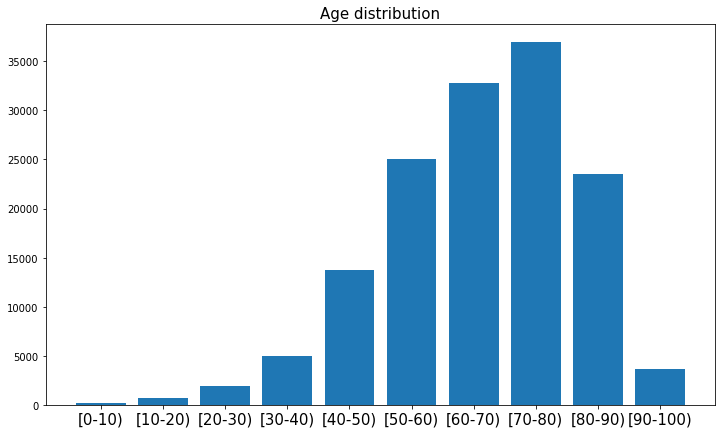

In [12]:
plt.figure(figsize=(12,7))
plt.bar(range(0,df['age'].nunique()), count_age)
plt.xticks(range(0,df['age'].nunique()), df['age'].unique(), fontsize=15)
plt.title('Age distribution', fontsize=15);

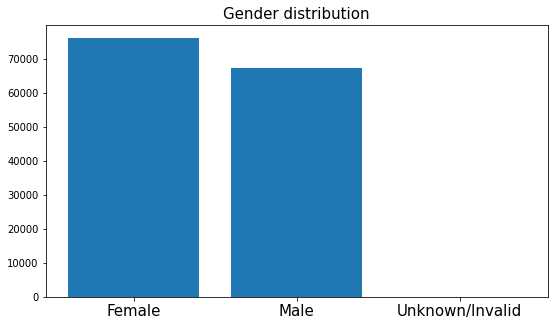

In [13]:
plt.figure(figsize=(9,5))
plt.bar(range(0, df['gender'].nunique()), count_gender)
plt.xticks(range(0,df['gender'].nunique()), df['gender'].unique(), fontsize=15)
plt.title('Gender distribution', fontsize=15);

In [14]:
len(df[df['gender'] == 'Unknown/Invalid'])

5

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site (https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [15]:
#NDC code lookup file
ndc_code_path = 'data/medication_lookup_tables/final_ndc_lookup_table'
ndc_code_df = pd.read_csv(ndc_code_path)

In [16]:
from utils.student_utils import reduce_dimension_ndc

In [17]:
df['ndc_code'].nunique()

251

In [18]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [19]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [20]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [21]:
len(df), len(reduce_dim_df)

(143424, 120020)

## Select First Encounter for each Patient

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [22]:
from utils.student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [23]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


## Aggregate Dataset to Right Level for Modeling

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [24]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/marta/Dokumenty/Udacity AI for Healthcare/Applying AI to EHR Data/Diabetes Drug Trial/diabetes_drug_trial/utils/utils.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [25]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [26]:
len(agg_drug_df), agg_drug_df['patient_nbr'].nunique(), agg_drug_df['encounter_id'].nunique()

(56133, 56133, 56133)

## Prepare Fields and Cast Dataset

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

**Response**: We shouldn't include these columns as they have too many unknown values ('?') as can be seen below.

In [27]:
agg_drug_df['payer_code'].value_counts()

?     23319
MC    16626
HM     3093
SP     2819
BC     2684
MD     1860
CP     1558
UN     1522
CM     1120
OG      562
PO      372
DM      305
WC       98
CH       90
OT       50
SI       28
MP       26
FR        1
Name: payer_code, dtype: int64

In [28]:
agg_drug_df['weight'].value_counts()

?            54127
[75-100)       840
[50-75)        542
[100-125)      392
[125-150)      104
[25-50)         58
[0-25)          36
[150-175)       23
[175-200)        8
>200             3
Name: weight, dtype: int64

In [29]:
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole_And_Metformin_Hydrochloride',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

In [30]:
agg_drug_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted',
       'generic_drug_name_array', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glyburide', 'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone',
       'Pioglitazone_Hydrochloride_And_Glimepiride', 'Repaglinide',
       '

In [31]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ['max_glu_serum', 'readmitted'] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ['number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'

In [32]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list
    
    return agg_drug_df[selected_col_list]

In [33]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list, PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

**Answer**: Zero may be too dummy value and this may mislead the model. We don't always know if chosen number, like zero, is legitimate in every case. There are other approaches like filling with mean or median value.

In [34]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
                             student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/marta/Dokumenty/Udacity AI for Healthcare/Applying AI to EHR Data/Diabetes Drug Trial/diabetes_drug_trial/utils/utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/marta/Dokumenty/Udacity AI for Healthcare/Applying AI to EHR Data/Diabetes Drug Trial/diabetes_drug_trial/utils/utils.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/marta/Dokumenty/Udacity AI for Healthcare/Applying AI to EHR Data/Diabete

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions (train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [35]:
from utils.student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [36]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [37]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0      7532
2.0      9473
3.0     10028
4.0      7681
5.0      5566
6.0      4122
7.0      3231
8.0      2419
9.0      1655
10.0     1292
11.0     1054
12.0      807
13.0      702
14.0      571
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


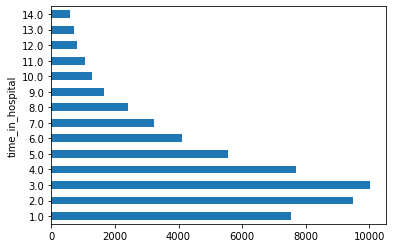

In [38]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4563
2.0     5695
3.0     6036
4.0     4562
5.0     3321
6.0     2486
7.0     1926
8.0     1428
9.0      993
10.0     815
11.0     614
12.0     482
13.0     410
14.0     348
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


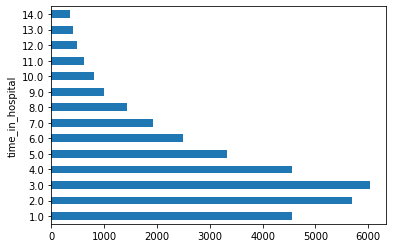

In [39]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1474
2.0     1886
3.0     1972
4.0     1547
5.0     1103
6.0      838
7.0      664
8.0      508
9.0      338
10.0     238
11.0     227
12.0     177
13.0     144
14.0     111
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


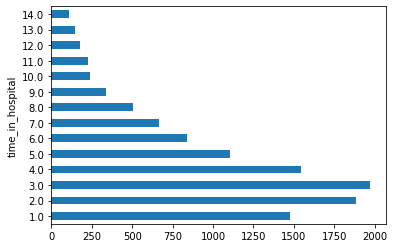

In [40]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

### Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             29583
Male               26548
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


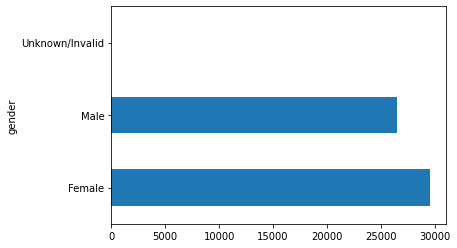

In [41]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             17719
Male               15958
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


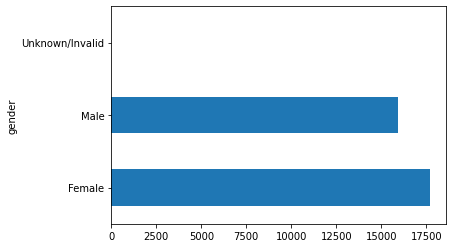

In [42]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    5905
Male      5322
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


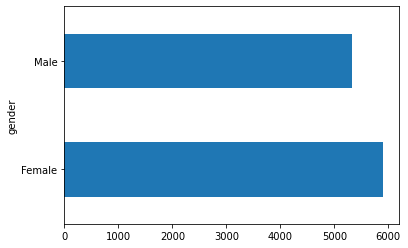

In [43]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Save the dataframes

In [44]:
d_train.to_csv('data/d_train.csv', index=False)
d_val.to_csv('data/d_val.csv', index=False)
d_test.to_csv('data/d_test.csv', index=False)